Aanvraag / besluit classifier

In [174]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve

%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomUniform
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
 

from stats import list_stats, show_train_curves, show_prediction_list, show_prediction_images
# from stats import show_train_curves
from data import load_data, split_data
from image_display import show_image

# Hot reload packages
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [175]:
img_dim = (200, 200, 3);
img_dim = (250, 250, 3);
# img_dim = (300, 300, 3);
# img_dim = (400, 400, 3);
IMG_DIR = f'examples/aanvraag_besluit/resized/{img_dim[0]}x{img_dim[1]}/'
LABEL_DIR = 'examples/aanvraag_besluit/labels/'


[X, Y_yaml, ids] = load_data(IMG_DIR, LABEL_DIR)
X = X / 255.  # normalize image data between 0 and 1
Y_type = np.array([y.get('type') for y in Y_yaml])

print(f"shape X: {X.shape}")
print(f"shape Y: {Y_type.shape}")
print(f"len ids: {len(ids)}")

def shuffle(X, Y, ids):
    assert isinstance(ids, list)
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    ids_shuffled = [ids[i] for i in indices]
    return (X_shuffled, Y_shuffled, ids_shuffled)

# print('shuffling X, Y and ids')
# X_shuffled, Y_shuffled, ids_shuffled = shuffle(X, Y_type, ids)
# X = X_shuffled
# Y_type = Y_shuffled
# ids = ids_shuffled

print(f"shape X: {X.shape}")
print(f"shape Y: {Y_type.shape}")
print(f"len ids: {len(ids)}")

list_stats(Y_type)

first few ids: ['SA00006999_00001', 'SA00009974_00001', 'SA00009975_00001', 'SA00009978_00001', 'SA00010588_00001']
shape X: (412, 250, 250, 3)
shape Y: (412,)
len ids: 412
shape X: (412, 250, 250, 3)
shape Y: (412,)
len ids: 412
classes: 2
classes with count less than 5 ignored
count classes: [['aanvraag', 246], ['other', 166]]
largest class: aanvraag, count: 246
total count: 412
score to beat: 0.5970873786407767


In [176]:
# Convert string to idx
types = list(set(Y_type))
num_classes = len(types)
print(f"number of classes: {num_classes}")
print(f"types encountered: {types}")

def convert_to_index(Y, types):
    return np.array([types.index(y) for y in Y])

Yind = convert_to_index(Y_type, types)
print(Y_type[:3])
print(Yind[:3])

list_stats(Yind)

number of classes: 2
types encountered: ['aanvraag', 'other']
['other' 'other' 'aanvraag']
[1 1 0]
classes: 2
classes with count less than 5 ignored
count classes: [[0, 246], [1, 166]]
largest class: 0, count: 246
total count: 412
score to beat: 0.5970873786407767


In [177]:
Y = keras.utils.to_categorical(Yind, num_classes)  # convert class vectors to binary class matrices
print(Yind.shape)
print(Y.shape)
print(Y[:10])

(412,)
(412, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [178]:
if num_classes == 2:
    Y_tmp = np.argmax(Y, axis=1)
    assert len(Y_tmp.shape) == 1
    Y = Y_tmp
    

In [180]:
# Split to train and test
SPLIT = 0.8

# (X_train, Y_train), (X_test, Y_test) = split_data(X, Yscaled, SPLIT)
(X_train, Y_train, ids_train), (X_test, Y_test, ids_test) = split_data(X, Y, ids, SPLIT)

print("split data shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")
print(f"ids_train: {len(ids_train)}")
print(f"ids_test: {len(ids_test)}")

split data shapes:
X_train: (329, 250, 250, 3)
Y_train: (329,)
X_test: (83, 250, 250, 3)
Y_test: (83,)
ids_train: 329
ids_test: 83


# Define model

In [181]:
# def build_model(num_classes, img_dim):
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=img_dim))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model


def build_model(num_classes, img_dim):
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='linear', input_shape=img_dim))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(32, activation='linear', kernel_initializer = RandomUniform()))
    model.add(LeakyReLU(alpha=0.1))
    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid', name='output'))
    else:
        model.add(Dense(num_classes, activation='softmax', name='output'))
    
    return model


def build_medium_size(num_classes, img_dim):
    # src: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_dim))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model(num_classes, img_dim)
# model = build_vgg16(num_classes, img_dim)
# model = build_medium_size(num_classes, img_dim)
model.summary()

(250, 250, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 248, 248, 16)      448       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 248, 248, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 124, 124, 16)      0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 122, 122, 32)      4640      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 61, 61, 32)        0      

# Train

Epoch 1/5
4/4 [==============================] - 24s 6s/step - loss: 1.3092 - acc: 0.4985 - val_loss: 0.6651 - val_acc: 0.6988
Epoch 2/5
4/4 [==============================] - 18s 5s/step - loss: 0.6960 - acc: 0.5735 - val_loss: 0.6898 - val_acc: 0.6988
Epoch 3/5
4/4 [==============================] - 11s 3s/step - loss: 0.6880 - acc: 0.5686 - val_loss: 0.6903 - val_acc: 0.6988
Epoch 4/5
4/4 [==============================] - 17s 4s/step - loss: 0.6887 - acc: 0.5735 - val_loss: 0.6951 - val_acc: 0.3976
Epoch 5/5
4/4 [==============================] - 22s 6s/step - loss: 0.6850 - acc: 0.5784 - val_loss: 0.6819 - val_acc: 0.6988


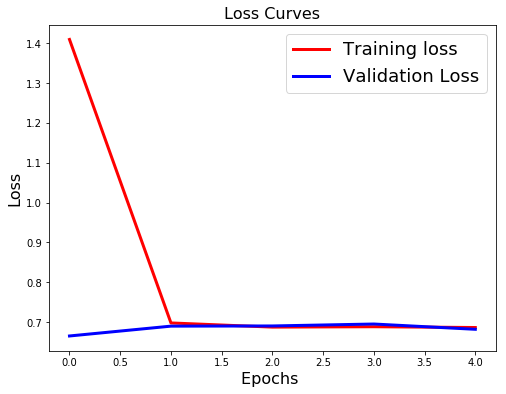

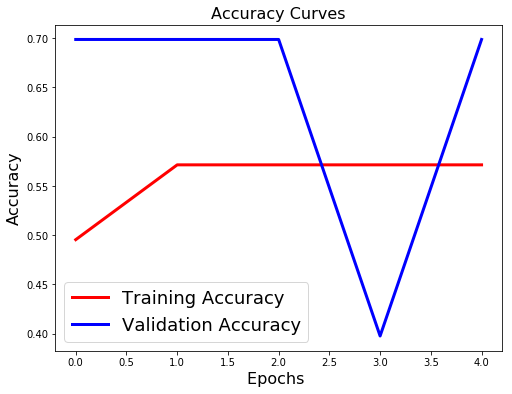

In [182]:
batch_size = 100
epochs = 5

datagen = ImageDataGenerator(
        zoom_range=0.1,        # randomly zoom into images
        rotation_range=5,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
)
 

def is_binary(model):
    n_classes = model.get_layer('output').output_shape[1]
    return n_classes == 1
    
def compile_model(model):
    assert(K.image_data_format() == 'channels_last')
    
    if is_binary(model):
        loss= keras.losses.binary_crossentropy
    else:
        loss=keras.losses.categorical_crossentropy
    
    model.compile(
        loss=loss,
#         optimizer=keras.optimizers.Adadelta(),
#         optimizer='rmsprop',
        optimizer=keras.optimizers.Adam(),        
        metrics=['accuracy']
    )

def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit(X_train, Y_train_tmp,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test)
           )
    return history

def train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_test, Y_test),
        workers=4
    )
    return history
# history = train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)
history = train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)


show_train_curves(history)

In [184]:
# Y_train = np.argmax(Y_train, axis=1)
# Y_test = np.argmax(Y_test, axis=1)

In [185]:
train_score = model.evaluate(X_train, Y_train, verbose=1)
print('Train loss:', round(train_score[0], 3))
print(f'Train accuracy: {round(train_score[1] * 100, 2)}%')

test_score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', round(test_score[0], 3))
test_acc_str = f'{round(test_score[1] * 100, 2)}%'
print(f'Test accuracy: {test_acc_str}')


329/329 [==============================] - 5s 14ms/step
Train loss: 0.689
Train accuracy: 57.14%
83/83 [==============================] - 1s 12ms/step
Test loss: 0.682
Test accuracy: 69.88%


In [200]:
print(f"types: {types}")

print("train predictions, truth")
# predictions_train =  model.predict(X_train, verbose=1)
show_prediction_list(predictions_train, Y_train)

print("test predictions, truth")
predictions_test = model.predict(X_test, verbose=1)
show_prediction_list(predictions_test, Y_test)

types: ['aanvraag', 'other']
train predictions, truth
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
expected:   [1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0]
test predictions, truth
83/83 [==============================] - 1s 13ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
expected:   [0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1]


SU10108198_00001


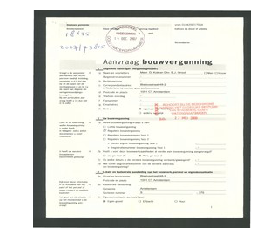

In [187]:
idx = 11
print(ids_test[idx])
show_image(X_test, idx)

train set:


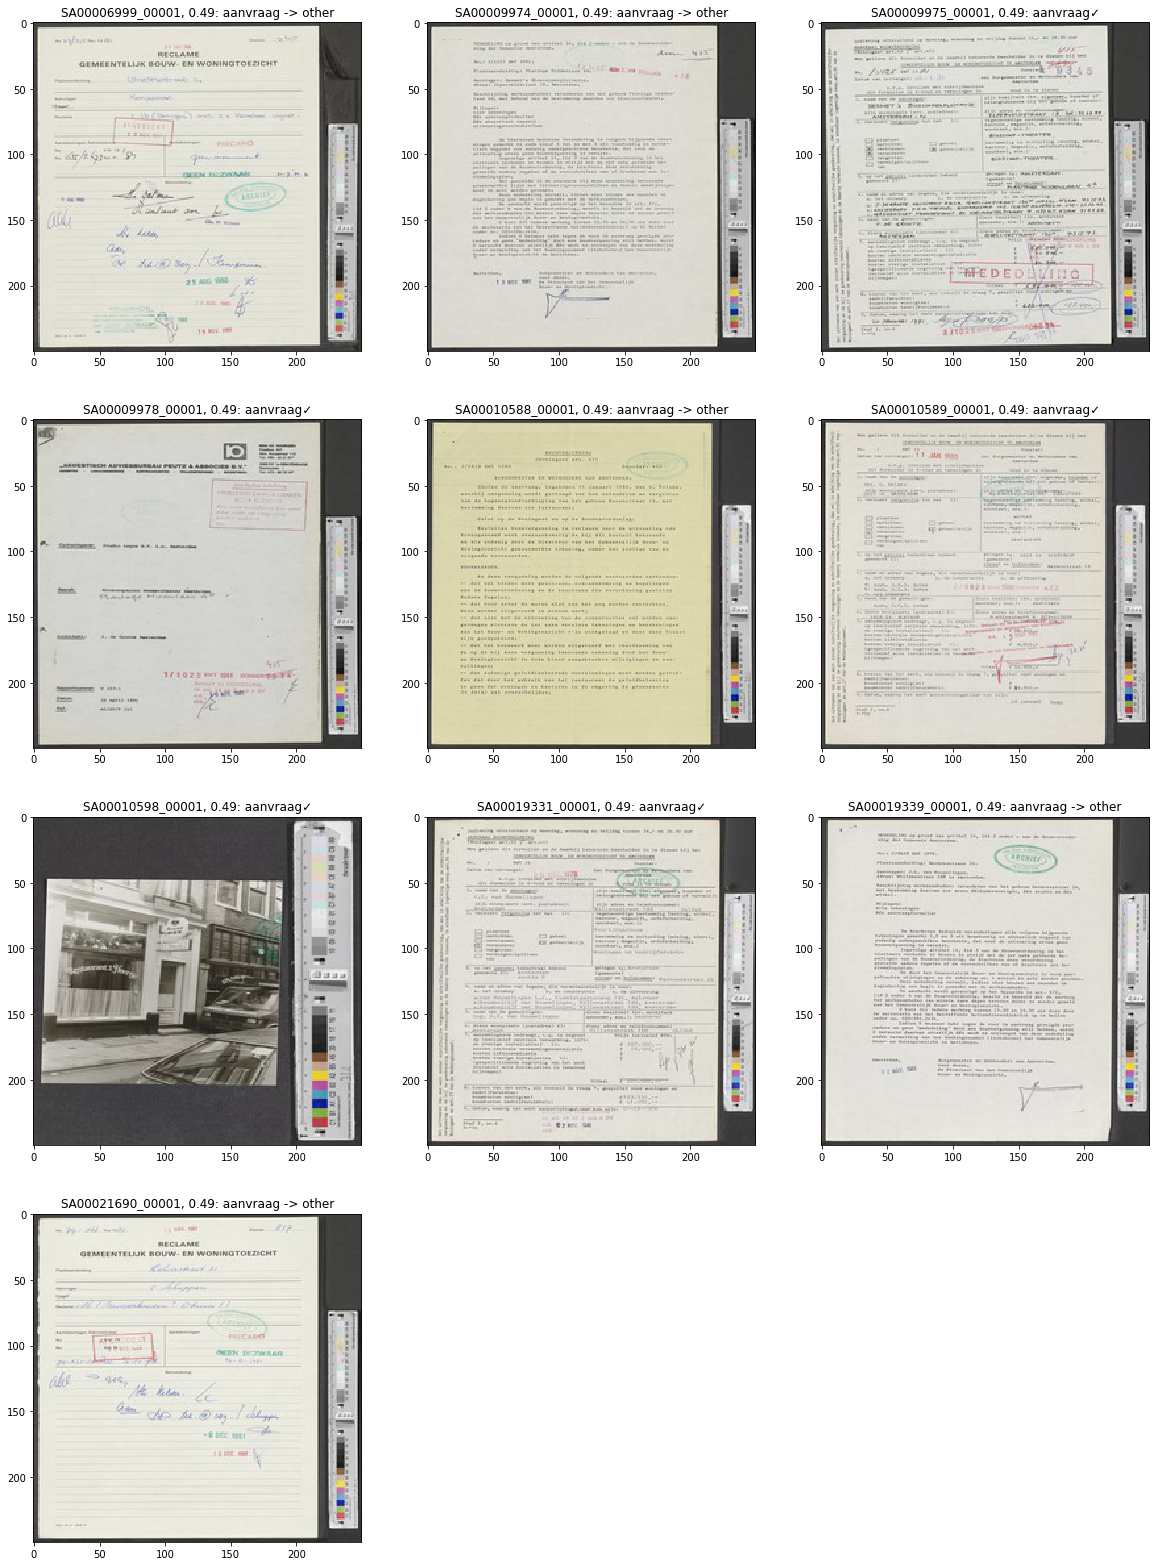

test set:


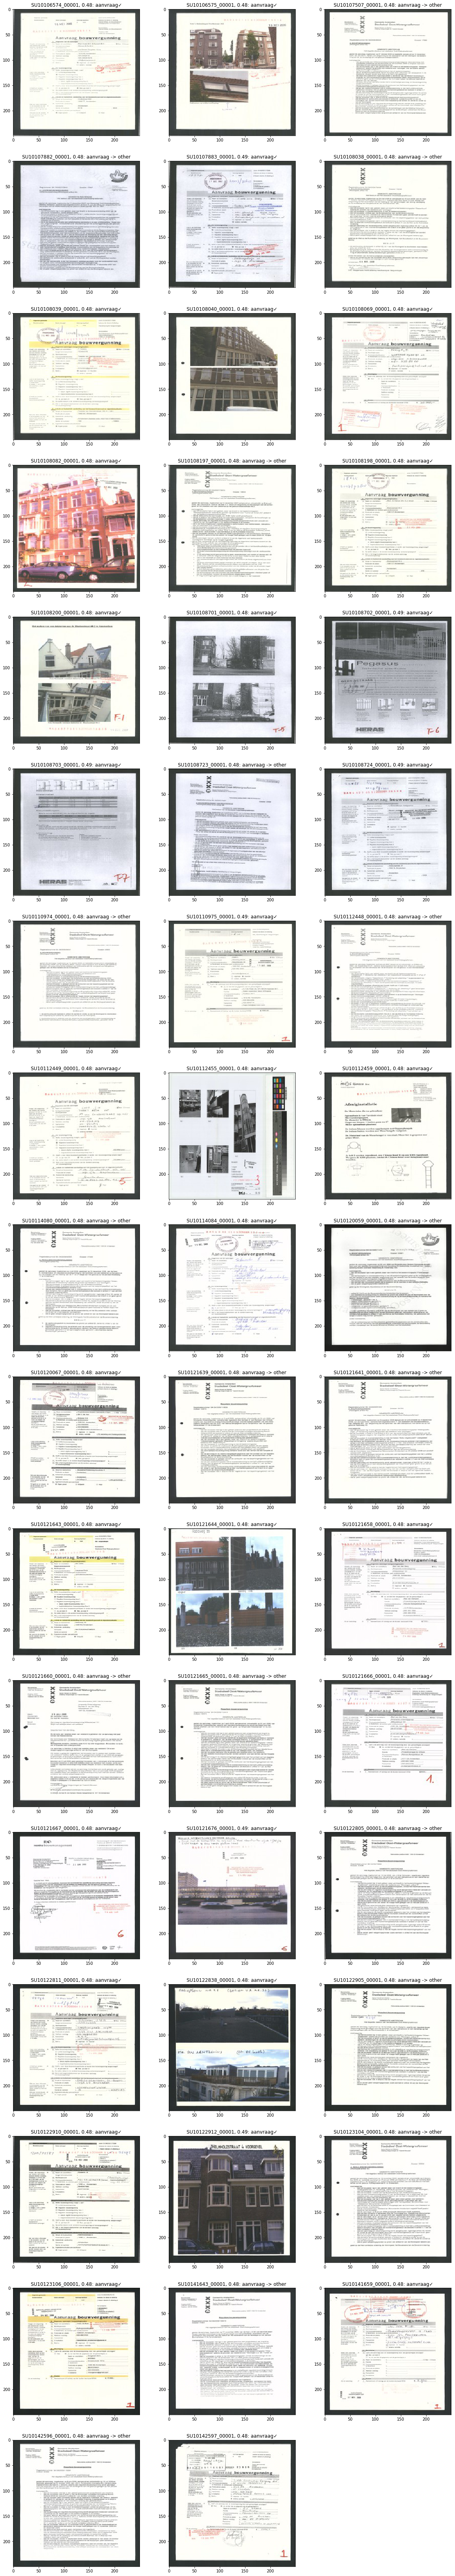

In [206]:
# Y_train_idx = np.argmax(Y_train, axis=1)        
# Y_test_idx = np.argmax(Y_test, axis=1)

print("train set:")
show_prediction_images(X_train, Y_train_idx, ids_train, predictions_train, types, 10)

print("test set:")
show_prediction_images(X_test, Y_test_idx, ids_test, predictions_test, types, 50)

In [190]:
# def multi_class_to_binary(class_true: np.ndarray, class_pred: np.ndarray):
#     # Converting to probablilty that Y_true == 1
#     assert class_true.shape[1] == 2  # 2 classes
#     assert class_pred.shape[1] == 2  # 2 classes
#     assert class_true.shape[0] == class_pred.shape[0]
    
#     y_true = np.argmax(class_true, axis=1)
    
# #     pred_ids = np.argmax(class_pred, axis=1)
# #     y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
#     y_prob = class_pred[:, 1]
#     assert y_true.shape == y_prob.shape
#     return [y_true, y_prob]
    
# [y_true, y_prob] = multi_class_to_binary(Y_test, predictions_test)


In [193]:
print(y_true[0:20])
print(np.round(predictions_test[0:20], 3))
predictions_test.shape
# print(np.round(y_prob[0:10], 3))

[0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0]
[[0.485]
 [0.482]
 [0.484]
 [0.484]
 [0.485]
 [0.485]
 [0.484]
 [0.484]
 [0.485]
 [0.48 ]
 [0.484]
 [0.484]
 [0.482]
 [0.482]
 [0.486]
 [0.486]
 [0.484]
 [0.485]
 [0.485]
 [0.486]]


(83, 1)

In [194]:
# class_pred = predictions_test
# pred_ids = np.argmax(class_pred, axis=1)
# y_prob = class_pred[range(class_pred.shape[0]), pred_ids]
y_prob = predictions_test

accuracy: 69.88%
confidence avg: 48.45%


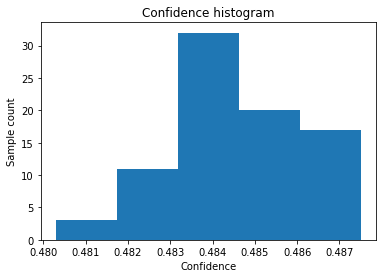

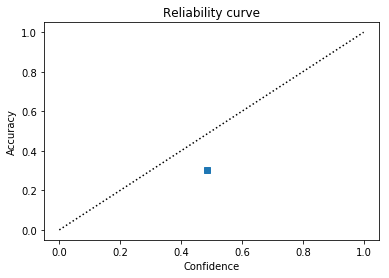

In [195]:
# reference https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

n_bins = 5

print(f'accuracy: {test_acc_str}')
conf_avg = np.average(predictions_test)
conf_avg_str = f'{round(conf_avg * 100, 2)}%'
print(f'confidence avg: {conf_avg_str}')

def draw_confidence_histogram(y_prob, n_bins):
    plt.figure()
    plt.title('Confidence histogram')
    plt.xlabel("Confidence")
    plt.ylabel("Sample count")
    plt.hist(y_prob, bins=n_bins)    
draw_confidence_histogram(y_prob, n_bins=n_bins)

def draw_reliability_curve(y_true, y_prob, n_bins):
    plt.figure()
    plt.title('Reliability curve')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    [prob_true_bins, prob_pred_bins] = calibration_curve(y_true, y_prob, n_bins=n_bins)

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_bins, prob_true_bins, marker='s')
draw_reliability_curve(y_true, y_prob, n_bins)
